In [2]:
import random, os
from pathlib import Path
import numpy  as np

# do this before importing tensorflow to get rid of annoying warning messages
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import matplotlib.pyplot as plt

In [3]:
# specify image size
target_shape = (200,200)   #(245, 200)

#### Data Preparation

In [5]:
"""
    load image jpeg image from file and resize into the target shape
"""
def preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, target_shape)
    return img

""" 
    preprocess a triplet of images given their filenames
"""
def preprocess_triplets(anchor, positive, negative):
    return (preprocess_image(anchor), preprocess_image(positive), preprocess_image(negative))



In [6]:
anchor_images_path = "./dataset/left/"
positive_images_path = "./dataset/right/"
batch_size = 32

In [9]:
for f in os.listdir(anchor_images_path):
    print(anchor_images_path+f)

./dataset/left/00083.jpg
./dataset/left/00417.jpg
./dataset/left/00491.jpg
./dataset/left/03351.jpg
./dataset/left/03260.jpg
./dataset/left/05746.jpg
./dataset/left/02872.jpg
./dataset/left/00740.jpg
./dataset/left/03203.jpg
./dataset/left/04902.jpg
./dataset/left/04245.jpg
./dataset/left/05369.jpg
./dataset/left/05141.jpg
./dataset/left/03012.jpg
./dataset/left/00615.jpg
./dataset/left/01439.jpg
./dataset/left/04943.jpg
./dataset/left/01816.jpg
./dataset/left/03648.jpg
./dataset/left/04147.jpg
./dataset/left/04197.jpg
./dataset/left/04115.jpg
./dataset/left/03267.jpg
./dataset/left/04020.jpg
./dataset/left/05781.jpg
./dataset/left/01473.jpg
./dataset/left/05603.jpg
./dataset/left/01231.jpg
./dataset/left/01181.jpg
./dataset/left/00867.jpg
./dataset/left/04655.jpg
./dataset/left/04545.jpg
./dataset/left/03042.jpg
./dataset/left/00194.jpg
./dataset/left/03057.jpg
./dataset/left/03464.jpg
./dataset/left/04465.jpg
./dataset/left/03007.jpg
./dataset/left/01117.jpg
./dataset/left/00651.jpg


In [10]:
# load anchor and positive images (make sure they're in the right order) 
anchor_images = sorted([str(anchor_images_path + f) for f in os.listdir(anchor_images_path)])
positive_images = sorted([str(positive_images_path + f) for f in os.listdir(positive_images_path)])
image_count = len(anchor_images)

# create tensorflow datasets
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

# create a negative dataset from the combines shuffled images
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

# create a triplet dataset
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)

# convert filenames to preprocessed images
dataset = dataset.map(preprocess_triplets) 

# 80-20 training and validation splits
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

2023-10-12 19:09:43.372314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 19:09:43.460828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 19:09:43.461327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 19:09:43.465848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-12 19:09:43.466229: I tensorflow/compile

#### Visualising the dataset

2023-10-12 19:17:28.113878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6016]
	 [[{{node Placeholder/_0}}]]
2023-10-12 19:17:28.114154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [12032]
	 [[{{node Placeholder/_4}}]]


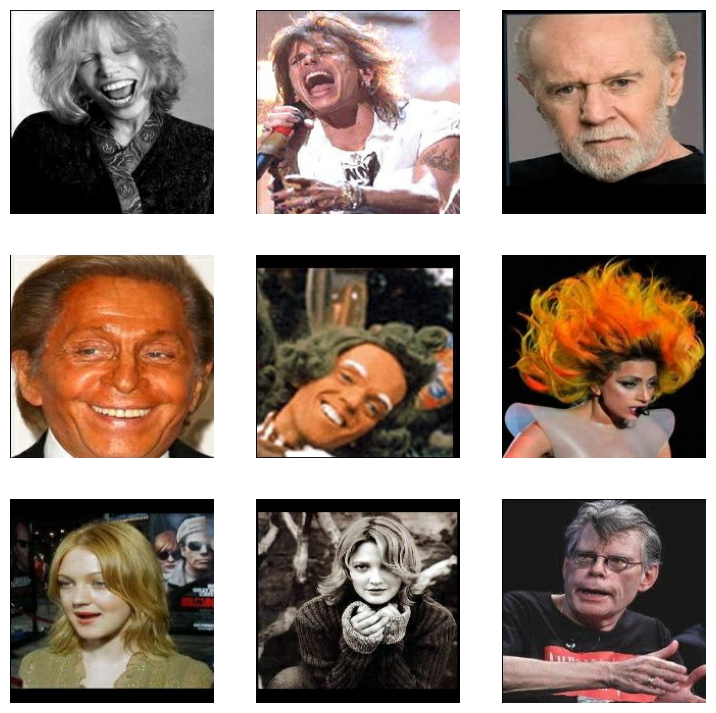

In [17]:
def visualize(anchor, positive, negative):
    
    def show(ax, image):
        ax.imshow(image)
        ax.axis('off')
        

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(3, 3)
        
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])
